## 一、项目背景
基于PaddleHub以及 WeChaty分析一个人的照片，为其装扮酷酷的样子，目前实现了染发，戴墨镜，变奥特曼。主要用到的模型是人脸关键点检测和人像细粒度分割，后续要拓展到更多的应用。

本项目是参加【**AI ChatBot 创意赛**】的作品，PaddleHub携手开源聊天机器人框架WeChaty带来 AI ChatBot创意赛，为AI算法工程师提供一个全新的应用场景：Chatbot （Conversational AI），同时也为Chatbot 开发者提供一个全新的AI能力平台，拓宽视野，为未来设计更加强大的 Chatbot 提供一扇门。

本项目主要难点对图像的处理，里面涉及到很多图像算法，对于新手来说不太友好。

本项目尝试了基于PaddleHub进行迁移训练人像分割模型， 使用到自定义数据集，虽然效果不如paddlehub官方提供的模型好，但对新手来讲还是有启发意义的。

参考项目：

[PaddleHub：人脸检测主题创意赛](https://aistudio.baidu.com/aistudio/projectdetail/1915945)

[Hi，兄弟，来开AI发廊嘛？](https://aistudio.baidu.com/aistudio/projectdetail/157446)

<iframe style="width:98%;height: 450px;" src="//player.bilibili.com/player.html?aid=248085270&bvid=BV1bv41157nN&cid=336355103&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true"> </iframe>

b站链接: [https://www.bilibili.com/video/BV1bv41157nN/](https://www.bilibili.com/video/BV1bv41157nN/)

## 二、关于WeChaty和PaddleHub

wechaty（https://github.com/wechaty/wechaty）是一款开源的微信SDK，它基于微信公开的API，对接口进行了一系列的封装，提供一系列简单的接口，然后开发者可以在其之上进行微信机器人的开发。

PaddleHub 是基于 PaddlePaddle 开发的预训练模型管理工具，可以借助预训练模型更便捷地开展迁移学习工作，旨在让 PaddlePaddle 生态下的开发者更便捷体验到大规模预训练模型的价值。

关于二者的结合使用请参考我的另一个公开项目：
	[微信医聊自动问答 WeChaty + PaddleHub](https://aistudio.baidu.com/aistudio/projectdetail/1868162)
    
这里使用docker脚本可方便快速部署。请将your_token处替换成你的WeChaty token (**puppet_padlocal_xxxxxxxxxxxxx)**

```
export WECHATY_LOG="verbose"
export WECHATY_PUPPET="wechaty-puppet-padlocal"
export WECHATY_PUPPET_PADLOCAL_TOKEN="your_token"

export WECHATY_PUPPET_SERVER_PORT="8080"
export WECHATY_TOKEN="your_token"

docker run -ti \
  --name wechaty_puppet_service_token_gateway \
  --rm \
  -e WECHATY_LOG \
  -e WECHATY_PUPPET \
  -e WECHATY_PUPPET_PADLOCAL_TOKEN \
  -e WECHATY_PUPPET_SERVER_PORT \
  -e WECHATY_TOKEN \
  -p "$WECHATY_PUPPET_SERVER_PORT:$WECHATY_PUPPET_SERVER_PORT" \
  wechaty/wechaty:latest
~                        
```

运行成功后如下图:


![](https://ai-studio-static-online.cdn.bcebos.com/73f123bb9b37410eb49f834dc512226e014f3f53a77d42888b201833e8ef6942)


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

## 三、依赖安装

`!pip install puddlehub -U`



## 四、数据集处理

**数据集名称:** CelebAMask-HQ

**数据集介绍:**

CelebAMask-HQ is a large-scale face image dataset that has 30,000 high-resolution face images selected from the CelebA dataset by following CelebA-HQ. Each image has segmentation mask of facial attributes corresponding to CelebA.

The masks of CelebAMask-HQ were manually-annotated with the size of 512 x 512 and 19 classes including all facial components and accessories such as skin, nose, eyes, eyebrows, ears, mouth, lip, hair, hat, eyeglass, earring, necklace, neck, and cloth.

CelebAMask-HQ can be used to train and evaluate algorithms of face parsing, face recognition, and GANs for face generation and editing.


![](https://ai-studio-static-online.cdn.bcebos.com/8c333aa42c7b43999ca86d22137e36e272f9bb25930146789499ab5e273f00fa)



In [ ]:
#解压数据集
#!unzip ~/data/data65122/CelebAMask-HQ.zip

#仿照PaddleHub/paddlehub/datasets/opticdiscseg.py写数据读取器 celeba_dataset.py
import os
from typing import Callable
import paddle
import numpy as np
from PIL import Image

from paddlehub.datasets.base_seg_dataset import SegDataset
class CelebaSeg(SegDataset):
    def __init__(self,
                 transforms: Callable = None,
                 data_path: str = '/home/aistudio/data/data65122',
                 mode: str = 'train'):
        self.transforms = transforms
        mode = mode.lower()
        self.mode = mode
        self.file_list = list()
        self.num_classes = 19
        self.ignore_index = 255

        if mode not in ['train', 'val', 'test']:
            raise ValueError(
                "`mode` should be 'train', 'val' or 'test', but got {}.".format(
                    mode))
        if self.transforms is None:
            raise ValueError("`transforms` is necessary, but it is None.")
        if mode == 'train':
            file_path = os.path.join(data_path, 'CelebAMask-HQ', 'train_list.txt')
        elif mode == 'test':
            file_path = os.path.join(data_path, 'CelebAMask-HQ', 'test_list.txt')
        else:
            file_path = os.path.join(data_path, 'CelebAMask-HQ', 'val_list.txt')

        with open(file_path, 'r') as f:
            for line in f:
                items = line.strip().split()
                if len(items) != 2:
                    if mode == 'train' or mode == 'val':
                        raise Exception(
                            "File list format incorrect! It should be"
                            " image_name label_name\\n")
                    image_path = os.path.join(data_path, items[0])
                    grt_path = None
                else:
                    image_path = os.path.join(data_path, items[0])
                    grt_path = os.path.join(data_path, items[1])

                # print(image_path, grt_path)
                # exit()
                self.file_list.append([image_path, grt_path])

## 五、人脸解析模型训练

参考文档: [deeplabv3p_resnet50_voc](https://www.paddlepaddle.org.cn/hubdetail?name=deeplabv3p_resnet50_voc&en_category=ImageSegmentation)


**部分参数说明：**
* segmentation_transforms 数据增强模块定义了丰富的针对图像分割数据的预处理方式，用户可按照需求替换自己需要的数据预处理方式。
* transform: 数据预处理方式。
* mode: 选择数据模式，可选项有 train, test, val, 默认为train
* train_dataset: 训练时所用的数据集；
* epochs: 训练轮数；
* batch_size: 训练的批大小，如果使用GPU，请根据实际情况调整batch_size；
* num_workers: works的数量，默认为0；
* eval_dataset: 验证集；
* log_interval: 打印日志的间隔， 单位为执行批训练的次数。
* save_interval: 保存模型的间隔频次，单位为执行训练的轮数。


**注意:** PaddleHub迁移训练分割模型是暂不支持训练时验证eval

In [1]:
#用paddlehub迁移训练一个人脸解析模型
import paddlehub as hub
import paddle
from paddlehub.finetune.trainer import Trainer
from paddlehub.vision.segmentation_transforms import Compose, Resize, Normalize
transform = Compose([Resize(target_size=(512, 512)), Normalize()])

from celeba_dataset import CelebaSeg
train_reader = CelebaSeg(transform, data_path='/home/aistudio',  mode='train')
# eval_reader = CelebaSeg(transform, data_path='/home/aistudio/data/data65122/CelebAMask-HQ',  mode='val') #该模型不支持验证

model = hub.Module(name='deeplabv3p_resnet50_voc', num_classes=19, pretrained=None)

scheduler = paddle.optimizer.lr.PolynomialDecay(learning_rate=0.01, decay_steps=10000, power=0.9,  end_lr=0.0001)
optimizer = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())
trainer = Trainer(model, optimizer, checkpoint_dir='deeplab_ckpt', use_gpu=True)
trainer.train(train_reader, epochs=5, batch_size=16, log_interval=1000, save_interval=1) 

#若不想训练可以直接用这个 https://www.paddlepaddle.org.cn/hubdetail?name=ace2p&en_category=ImageSegmentation

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

load pretrained parameters success


[2021-05-10 09:11:45,142] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
[2021-05-10 09:52:30,399] [   TRAIN] - Epoch=1/5, Step=1000/1512 loss=0.3816 lr=0.009104 step/sec=0.41 | ETA 05:08:06
[2021-05-10 10:13:25,267] [    INFO] - Saving model checkpoint to deeplab_ckpt/epoch_1
[2021-05-10 10:54:21,274] [   TRAIN] - Epoch=2/5, Step=1000/1512 loss=0.2134 lr=0.007731 step/sec=0.41 | ETA 05:08:47
[2021-05-10 11:15:14,977] [   

KeyboardInterrupt: 

In [ ]:
#模型预测, 这里模型未训练充分
import paddle
import cv2
import paddlehub as hub

model = hub.Module(name='deeplabv3p_resnet50_voc', num_classes=19, pretrained='deeplab_ckpt/epoch_3/model.pdparams')
img = cv2.imread("liudehua.jpg")
print(img.shape)
model.predict(images=[img], visualization=True) #hub里的代码有问题，模型加载成功，但是预测时有bug

## 六、模型ace2p介绍

人体解析(Human Parsing)是细粒度的语义分割任务，其旨在识别像素级别的人类图像的组成部分（例如，身体部位和服装）。ACE2P通过融合底层特征，全局上下文信息和边缘细节，端到端地训练学习人体解析任务。该结构针对Intersection over Union指标进行针对性的优化学习，提升准确率。以ACE2P单人人体解析网络为基础的解决方案在CVPR2019第三届LIP挑战赛中赢得了全部三个人体解析任务的第一名。该PaddleHub Module采用ResNet101作为骨干网络，接受输入图片大小为473x473x3。

![](https://ai-studio-static-online.cdn.bcebos.com/e400e97f60104b3f89369b41c4156a19a0018ac6bd694f898a218cc00721ec3e)


[2021-05-10 00:36:34,805] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


(707, 544, 3)


(-0.5, 543.5, 706.5, -0.5)

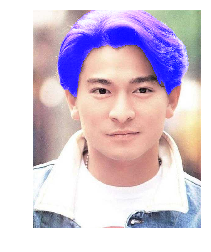

In [ ]:
#染发模型, 人脸解析中类别ID是2
import cv2
import paddlehub as hub
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
import math
%matplotlib inline

human_parser = hub.Module(name="ace2p")

color_config = {
    "green": (0, 255, 0),
    "white": (255, 255, 255),
    "red": (255, 0, 0),
    "blue": (0, 0, 255),
    "purple": (255, 0, 255)
}

def colorize_hair(img_path, color_type="purple"):
    ori_img = cv2.imread(img_path)
    print(ori_img.shape)
    result = human_parser.segmentation(images=[ori_img], visualization=False)

    if len(result) < 1:
        return ori_img

    # print(result) #头发类别ID=2
    rs = result[0]['data']
    target_color = color_config[color_type]
    for i in range(ori_img.shape[0]):
        for j in range(ori_img.shape[1]):
            if rs[i][j] == 2:
                for k in range(len(target_color)):
                    if target_color[k] == 0:
                        continue

                    # if ori_img[i][j][k] < 150:
                    #     ori_img[i][j][k] = 255 - ori_img[i][j][k]
                    ori_img[i][j][k] = 255
    return ori_img

#显示
img = colorize_hair("liudehua.jpg", "red")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
im = plt.imshow(img, animated=True)
plt.axis('off') 


## 七、模型face_landmark_localization介绍

人脸关键点检测是人脸识别和分析领域中的关键一步，它是诸如自动人脸识别、表情分析、三维人脸重建及三维动画等其它人脸相关问题的前提和突破口。该 PaddleHub Module 的模型转换自 https://github.com/lsy17096535/face-landmark ，支持同一张图中的多个人脸检测。

**参考文档：** https://www.paddlepaddle.org.cn/hubdetail?name=face_landmark_localization&en_category=KeyPointDetection

**参数说明:**
* images (list[numpy.ndarray]): 图片数据，ndarray.shape 为 [H, W, C]，BGR格式；
* paths (list[str]): 图片的路径；
* batch_size (int): batch 的大小；
* use_gpu (bool): 是否使用 GPU；
* visualization (bool): 是否将识别结果保存为图片文件；
* output_dir (str): 图片的保存路径，当为 None 时，默认设为face_landmark_output。

![](https://ai-studio-static-online.cdn.bcebos.com/c724082ebb0748fc85b7ab776b96029e1f6a923189634cd4b064678fbfe541cb)




2021-05-10 00:42:41,733 - INFO - Lock 140621390434704 acquired on /home/aistudio/.paddlehub/tmp/face_landmark_localization
[INFO 2021-05-10 00:42:41,733 filelock.py:274] Lock 140621390434704 acquired on /home/aistudio/.paddlehub/tmp/face_landmark_localization


Download https://bj.bcebos.com/paddlehub/paddlehub_dev/face_landmark_localization_1.0.2.tar.gz
[##################################################] 100.00%
Decompress /home/aistudio/.paddlehub/tmp/tmpt10dr19z/face_landmark_localization_1.0.2.tar.gz
[##################################################] 100.00%


[2021-05-10 00:42:44,465] [    INFO] - Successfully installed face_landmark_localization-1.0.2
2021-05-10 00:42:44,473 - INFO - Lock 140621390434704 released on /home/aistudio/.paddlehub/tmp/face_landmark_localization
[INFO 2021-05-10 00:42:44,473 filelock.py:318] Lock 140621390434704 released on /home/aistudio/.paddlehub/tmp/face_landmark_localization
[2021-05-10 00:42:44,474] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object
2021-05-10 00:42:44,476 - INFO - Lock 140622462789264 acquired on /home/aistudio/.paddlehub/tmp/ultra_light_fast_generic_face_detector_1mb_640
[INFO 2021-05-10 00:42:44,476 filelock.py:274] Lock 140622462789264 acquired on /home/aistudio/.paddlehub/tmp/ultra_light_fast_generic_face_detector_1mb_640


Download https://bj.bcebos.com/paddlehub/paddlehub_dev/ultra_light_fast_generic_face_detector_1mb_640_1.1.2.tar.gz
[##################################################] 100.00%
Decompress /home/aistudio/.paddlehub/tmp/tmpej4vpzab/ultra_light_fast_generic_face_detector_1mb_640_1.1.2.tar.gz
[##################################################] 100.00%


[2021-05-10 00:42:45,398] [    INFO] - Successfully installed ultra_light_fast_generic_face_detector_1mb_640-1.1.2
2021-05-10 00:42:45,409 - INFO - Lock 140622462789264 released on /home/aistudio/.paddlehub/tmp/ultra_light_fast_generic_face_detector_1mb_640
[INFO 2021-05-10 00:42:45,409 filelock.py:318] Lock 140622462789264 released on /home/aistudio/.paddlehub/tmp/ultra_light_fast_generic_face_detector_1mb_640
[2021-05-10 00:42:45,411] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


(707, 544, 4) 212 311 157 417


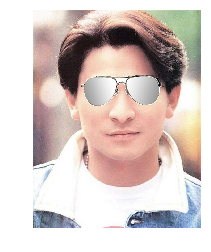

In [ ]:
#模型加载
module = hub.Module(name="face_landmark_localization")

def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
    bg_img = background_img.copy()
    # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2BGRA)

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

    b, g, r, a = cv2.split(img_to_overlay_t)
    mask = cv2.medianBlur(a, 5)

    h, w, _ = img_to_overlay_t.shape
    roi = bg_img[int(y - h / 2):int(y + h / 2), int(x - w / 2):int(x + w / 2)]
    print(bg_img.shape, int(y - h / 2), int(y + h / 2), int(x - w / 2), int(x + w / 2) )
    # print(img_to_overlay_t.shape, mask.shape,  background_img.shape, roi.shape)
    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)
    bg_img[int(y - h / 2):int(y + h / 2), int(x - w / 2):int(x + w / 2)] = cv2.add(img1_bg, img2_fg)

    # convert 4 channels to 3 channels
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGRA2BGR)
    return bg_img

#角度计算
from math import degrees, atan2
def angle_between(p1, p2):
    x_diff = p2[0] - p1[0]
    y_diff = p2[1] - p1[1]
    return degrees(atan2(y_diff, x_diff))

def wear_glasses(image, glasses, eye_left_center, eye_right_center):
    eye_left_center = np.array(eye_left_center)
    eye_right_center = np.array(eye_right_center)
    glasses_center = np.mean([eye_left_center, eye_right_center], axis=0)  # put glasses's center to this center
    glasses_size = np.linalg.norm(eye_left_center - eye_right_center) * 2  # the width of glasses mask
    angle = -angle_between(eye_left_center, eye_right_center)

    glasses_h, glasses_w = glasses.shape[:2]
    glasses_c = (glasses_w / 2, glasses_h / 2)
    M = cv2.getRotationMatrix2D(glasses_c, angle, 1)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((glasses_h * sin) + (glasses_w * cos))
    nH = int((glasses_h * cos) + (glasses_w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - glasses_c[0]
    M[1, 2] += (nH / 2) - glasses_c[1]

    rotated_glasses = cv2.warpAffine(glasses, M, (nW, nH))
    try:
        image = overlay_transparent(image, rotated_glasses, glasses_center[0], glasses_center[1],
                                    overlay_size=(
                                        int(glasses_size),
                                        int(rotated_glasses.shape[0] * glasses_size / rotated_glasses.shape[1]))
                                    )
    except:
        print('failed overlay image')
    return image

def get_eye_center_point(landmarks, idx1, idx2):
    center_x = (landmarks[idx1][0] + landmarks[idx2][0]) // 2
    center_y = (landmarks[idx1][1] + landmarks[idx2][1]) // 2
    return (center_x, center_y)

def create_glass_img(image_file):
    glasses_file = './glasses4.png'
    image = cv2.imread(image_file)
    glasses = cv2.imread(glasses_file, cv2.IMREAD_UNCHANGED)
    result = module.keypoint_detection(images=[image])
    landmarks = result[0]['data'][0]
    eye_left_point = get_eye_center_point(landmarks, 36, 39)
    eye_right_point = get_eye_center_point(landmarks, 42, 45)
    image = wear_glasses(image, glasses, eye_left_point, eye_right_point)
    cv2.imwrite(f'result.png', image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    im = plt.imshow(image, animated=True)
    plt.axis('off') 

create_glass_img("liudehua.jpg")

(707, 544, 4) 56 444 101 467


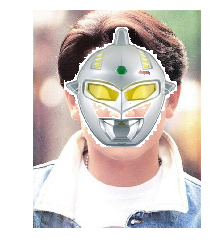

In [ ]:
auto_man_file = "./automan.png"
image_path = "./liudehua.jpg"
ref_eye_width = 149 - 75
ref_eye_mouth_height = 270 - 153
ref_img_width = 221
ref_img_height = 288
ref_left_eye = (75, 153)
auto_man_img = cv2.imread(auto_man_file)
auto_man_img = cv2.cvtColor(auto_man_img, cv2.COLOR_BGR2BGRA)

#白底设为透明
for i in range(auto_man_img.shape[0]):
    for j in range(auto_man_img.shape[1]):
        if auto_man_img[i][j][0] > 250 and auto_man_img[i][j][1] > 250 and auto_man_img[i][j][2] > 250:
            auto_man_img[i][j][3] = 0

def create_automan_img(image_file):
    image = cv2.imread(image_file)
    result = module.keypoint_detection(images=[image])
    landmarks = result[0]['data'][0]
    eye_left_point = get_eye_center_point(landmarks, 36, 39)
    eye_right_point = get_eye_center_point(landmarks, 42, 45)
    mouth_center_point = get_eye_center_point(landmarks, 49, 55)

    #计算待缩放的宽高并根据眼睛反推坐标
    new_img_width = (eye_right_point[0] - eye_left_point[0]) * ref_img_width / ref_eye_width
    # print("===>", image.shape, (eye_right_point[0] - eye_left_point[0]), ref_eye_width, ref_img_width, new_img_width)
    new_img_height = (mouth_center_point[1] - eye_left_point[1]) * ref_img_height / ref_eye_mouth_height
    # print(mouth_center_point, ref_img_height, ref_eye_mouth_height, new_img_height)

    offx = eye_left_point[0] - ref_left_eye[0] * (eye_right_point[0] - eye_left_point[0]) / ref_eye_width
    offy = eye_left_point[1] - ref_left_eye[1] * (mouth_center_point[1] - eye_left_point[1]) / ref_eye_mouth_height
    mid_x = int(offx + new_img_width / 2)
    mid_y = int(offy + new_img_height / 2)

    #图片拼接
    image = overlay_transparent(image, auto_man_img, mid_x, mid_y,
                            overlay_size=(int(new_img_height), int(new_img_width)))

    # image = wear_glasses(image, glasses, eye_left_point, eye_right_point)
    cv2.imwrite(f'result.png', image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    im = plt.imshow(image, animated=True)
    plt.axis('off') 

create_automan_img("liudehua.jpg")

## 八、在wechaty上部署查看效果

![](https://ai-studio-static-online.cdn.bcebos.com/7f5dff0b6b044f28bb9c43b350b65959ea7804ce257747c5872e7d61b664ec14)

![](https://ai-studio-static-online.cdn.bcebos.com/cb40d28c09d4447f8c600f0cc4449c7aecc07ff9950f496f82b5d5bab4f5b32d)





## 九、总结

本项目研究了人脸解析模型在PaddleHub上迁移训练， 相比之下使用官方自带的ace2p模型会更简便， 且效果更好。

后续将对图像处理逻辑做进一步研究，还有很多地方都需要改善，比如通过仿射变换适应更自由的角度， 面具白色的毛边处理等等， 还将集成更多的类似模型应用到本项目，请期待吧~~


**关于作者**

PaddlePaddle开发爱好者

我在AI Studio上获得黄金等级，点亮5个徽章，来互关呀~ https://aistudio.baidu.com/aistudio/personalcenter/thirdview/89442